In [1]:
# Estos dos comandos evitan que haya que hacer reload cada vez que se modifica un paquete
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

Anotaciones:
Desde el lado de Estadistica querriamos ver que tan bueno se aproxima a una gaussiana. Desde ML que tan bien generaliza

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

In [3]:
data = pd.read_csv('data/alturas-pesos-mils-train.csv')[:-1]

In [4]:
test = pd.read_csv('data/alturas-pesos-mils-test.csv')

In [5]:
from BiVariateJoint import BiVariateJoint

In [6]:
data_hombres = data.loc[data['Genero']=='Hombre'][['Peso','Altura']].values
data_mujeres = data.loc[data['Genero']=='Mujer'][['Peso','Altura']].values

# Bayes Gaussiano (Quadratic Discriminant Analisys)

In [7]:
peso_altura_hombres = data.loc[data['Genero']=='Hombre'][['Peso', 'Altura']].values
peso_altura_mujeres = data.loc[data['Genero']=='Mujer'][['Peso', 'Altura']].values

In [8]:
mean_hombres = peso_altura_hombres.mean(axis=0)
mean_mujeres = peso_altura_mujeres.mean(axis=0)

In [9]:
cov_hombres = np.cov(peso_altura_hombres.T)
cov_mujeres = np.cov(peso_altura_mujeres.T)

In [10]:
from scipy.stats import multivariate_normal

In [11]:
def get_gauss_prob(data, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres):
    data_np = data
    likelihood_class_1 = multivariate_normal.pdf(data_np, mean_hombres, cov_hombres)
    likelihood_class_2 = multivariate_normal.pdf(data_np, mean_mujeres, cov_mujeres)
    N_class_1 = len(peso_altura_hombres)
    N_class_2 = len(peso_altura_mujeres)
    prior_1 = N_class_1/(N_class_1 + N_class_2)
    prior_2 = N_class_2/(N_class_1 + N_class_2)
    total = likelihood_class_1 * prior_1 + likelihood_class_2 * prior_2
    p_class_1 = likelihood_class_1 * prior_1/total
    p_class_2 = likelihood_class_2 * prior_2/total
    return p_class_1, p_class_2

In [12]:
def get_acc_gauss(data, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres):
    p_class_1, p_class_2 = get_gauss_prob(data[['Peso', 'Altura']].values, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres)
    return ((p_class_1>p_class_2)==(data['Genero']=='Hombre')).sum()/len(p_class_1)

In [13]:
acc_QDA_train = get_acc_gauss(data, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres)
print(acc_QDA_train)

0.9167395924490561


In [14]:
acc_QDA_CV = get_acc_gauss(test, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres)
print(acc_QDA_CV)

0.9225


# LDA

In [15]:
mean_hombres = peso_altura_hombres.mean(axis=0)
mean_mujeres = peso_altura_mujeres.mean(axis=0)
cov_LDA = np.cov(np.vstack([peso_altura_hombres - mean_hombres, peso_altura_mujeres - mean_mujeres]).T)

In [16]:
acc_LDA_train = get_acc_gauss(data, mean_hombres, mean_mujeres, cov_LDA, cov_LDA)
print(acc_LDA_train)

0.9167395924490561


In [17]:
acc_LDA_CV = get_acc_gauss(test, mean_hombres, mean_mujeres, cov_LDA, cov_LDA)
print(acc_LDA_CV)

0.9225


# Naive Bayes Gaussiano

In [18]:
cov_hombres_nb = np.cov(peso_altura_hombres.T)*np.identity(2)
cov_mujeres_nb = np.cov(peso_altura_mujeres.T)*np.identity(2)

In [19]:
def get_prob_naive(data):
    data_np = data
    likelihood_class_1 = multivariate_normal.pdf(data_np, mean_hombres, cov_hombres*np.identity(2))
    likelihood_class_2 = multivariate_normal.pdf(data_np, mean_mujeres, cov_mujeres*np.identity(2))
    N_class_1 = len(peso_altura_hombres)
    N_class_2 = len(peso_altura_mujeres)
    prior_1 = N_class_1/(N_class_1 + N_class_2)
    prior_2 = N_class_2/(N_class_1 + N_class_2)
    total = likelihood_class_1 * prior_1 + likelihood_class_2 * prior_2
    p_class_1 = likelihood_class_1 * prior_1/total
    p_class_2 = likelihood_class_2 * prior_2/total
    return p_class_1, p_class_2

In [20]:
def get_acc_gauss_naive(data):
    p_class_1, p_class_2 = get_prob_naive(data[['Peso', 'Altura']].values)
    return ((p_class_1>p_class_2)==(data['Genero']=='Hombre')).sum()/len(p_class_1)

In [21]:
acc_NB_train = get_acc_gauss_naive(data)
print(acc_NB_train)

0.8869858732341542


In [22]:
acc_NB_CV = get_acc_gauss_naive(test)
print(acc_NB_CV)

0.887


# Regresion Logistica

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
log_Reg = LogisticRegression()

In [25]:
log_Reg.fit(data[['Peso', 'Altura']].values, data['Genero'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
acc_LR_train = log_Reg.score(data[['Peso', 'Altura']].values, data['Genero'])
print(acc_LR_train)

0.9166145768221028


In [27]:
acc_LR_CV = log_Reg.score(test[['Peso', 'Altura']].values, test['Genero'])
print(acc_LR_CV)

0.922


# Comparación

In [28]:
N = 300
X = np.linspace(data.min()['Peso'], data.max()['Peso'], N)
Y = np.linspace(data.min()['Altura'], data.max()['Altura'], N)
X, Y = np.meshgrid(X, Y)
# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

In [29]:
Z_H = multivariate_normal.pdf(pos, mean_hombres, cov_hombres)
Z_M = multivariate_normal.pdf(pos, mean_mujeres, cov_mujeres)
Z_gaus, _ = get_gauss_prob(pos, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres)

Z_H_LDA = multivariate_normal.pdf(pos, mean_hombres, cov_LDA)
Z_M_LDA = multivariate_normal.pdf(pos, mean_mujeres, cov_LDA)
Z_LDA, _ = get_gauss_prob(pos, mean_hombres, mean_mujeres, cov_LDA, cov_LDA)

Z_H_nb = multivariate_normal.pdf(pos, mean_hombres, cov_hombres*np.identity(2))
Z_M_nb = multivariate_normal.pdf(pos, mean_mujeres, cov_mujeres*np.identity(2))
Z_nb, _ = get_prob_naive(pos)

Z_lr = log_Reg.predict_proba(np.c_[X.ravel(), Y.ravel()])[:, 0]
Z_lr = Z_lr.reshape(X.shape)

In [30]:
def roundAcc(acc):
    return str(np.round(acc*100)/100)

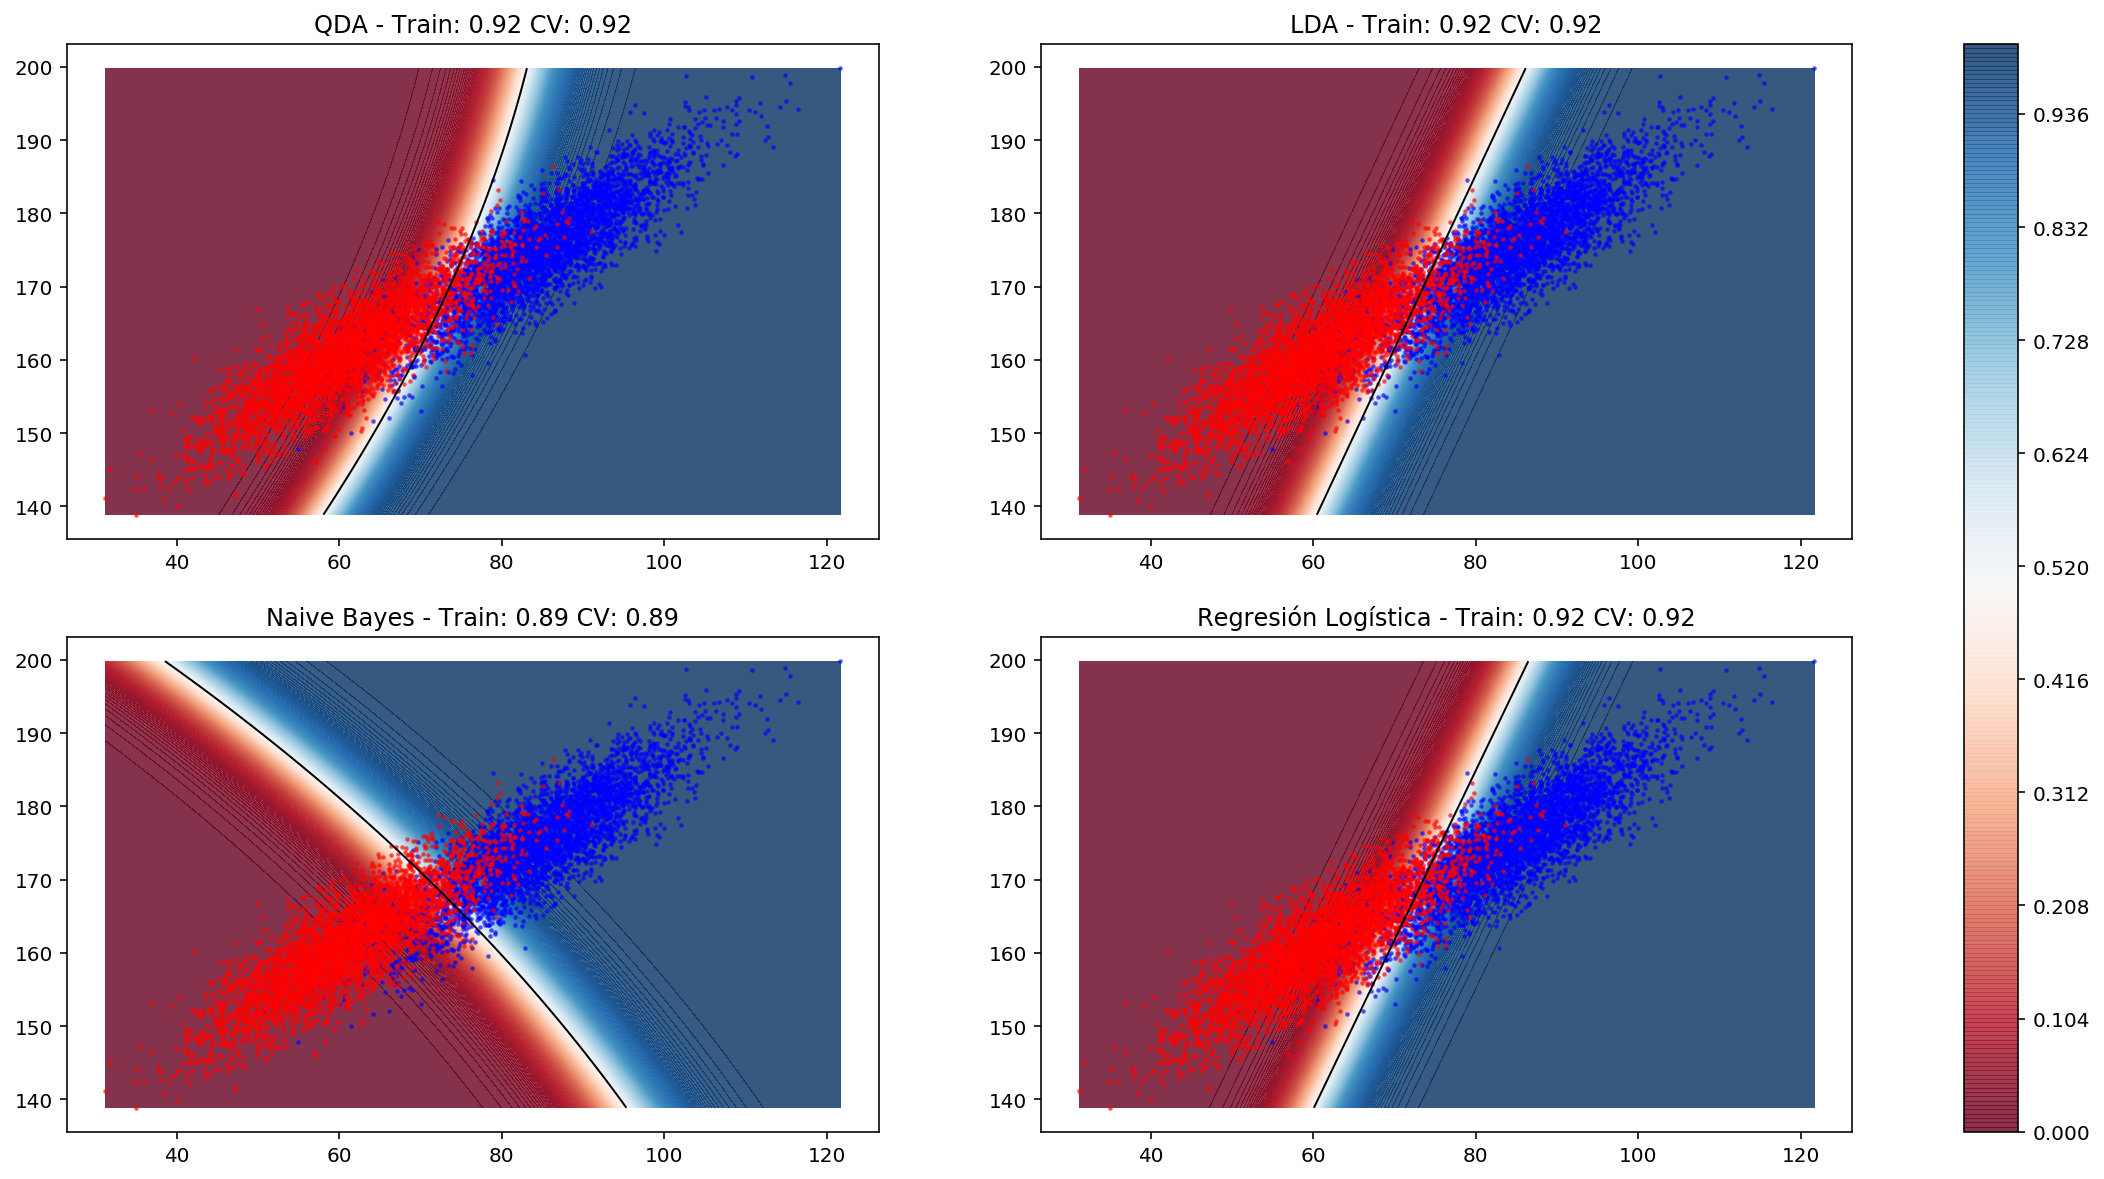

In [31]:
#%matplotlib qt
alpha = 0.5
f, ax = plt.subplots(2,2, figsize=(20,10))
ax = ax.reshape(-1)
cm = plt.cm.RdBu
cf = ax[0].contourf(X, Y, Z_gaus, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
ax[0].contour(X, Y, Z_gaus, (0.5,), colors='k', linewidths=1)
ax[0].set_title("QDA - Train: " + roundAcc(acc_QDA_train) + " CV: " + roundAcc(acc_QDA_CV))
ax[1].contourf(X, Y, Z_LDA, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
ax[1].contour(X, Y, Z_LDA, (0.5,), colors='k', linewidths=1)
ax[1].set_title("LDA - Train: " + roundAcc(acc_LDA_train) + " CV: " + roundAcc(acc_LDA_CV))
ax[2].contourf(X, Y, Z_nb, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
ax[2].contour(X, Y, Z_nb, (0.5,), colors='k', linewidths=1)
ax[2].set_title("Naive Bayes - Train: " + roundAcc(acc_NB_train) + " CV: " + roundAcc(acc_NB_CV))
ax[3].contourf(X, Y, Z_lr, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
ax[3].contour(X, Y, Z_lr, (0.5,), colors='k', linewidths=1)
ax[3].set_title("Regresión Logística - Train: " + roundAcc(acc_LR_train) + " CV: " + roundAcc(acc_LR_CV))

plt.colorbar(cf, ax=ax)
z_levels = np.logspace(-5,-2,10)/4
for a in ax:
    a.scatter(data_hombres[:,0], data_hombres[:,1], color='b', s=2, alpha=alpha)
    a.scatter(data_mujeres[:,0], data_mujeres[:,1], color='r', s=2, alpha=alpha)
plt.show()

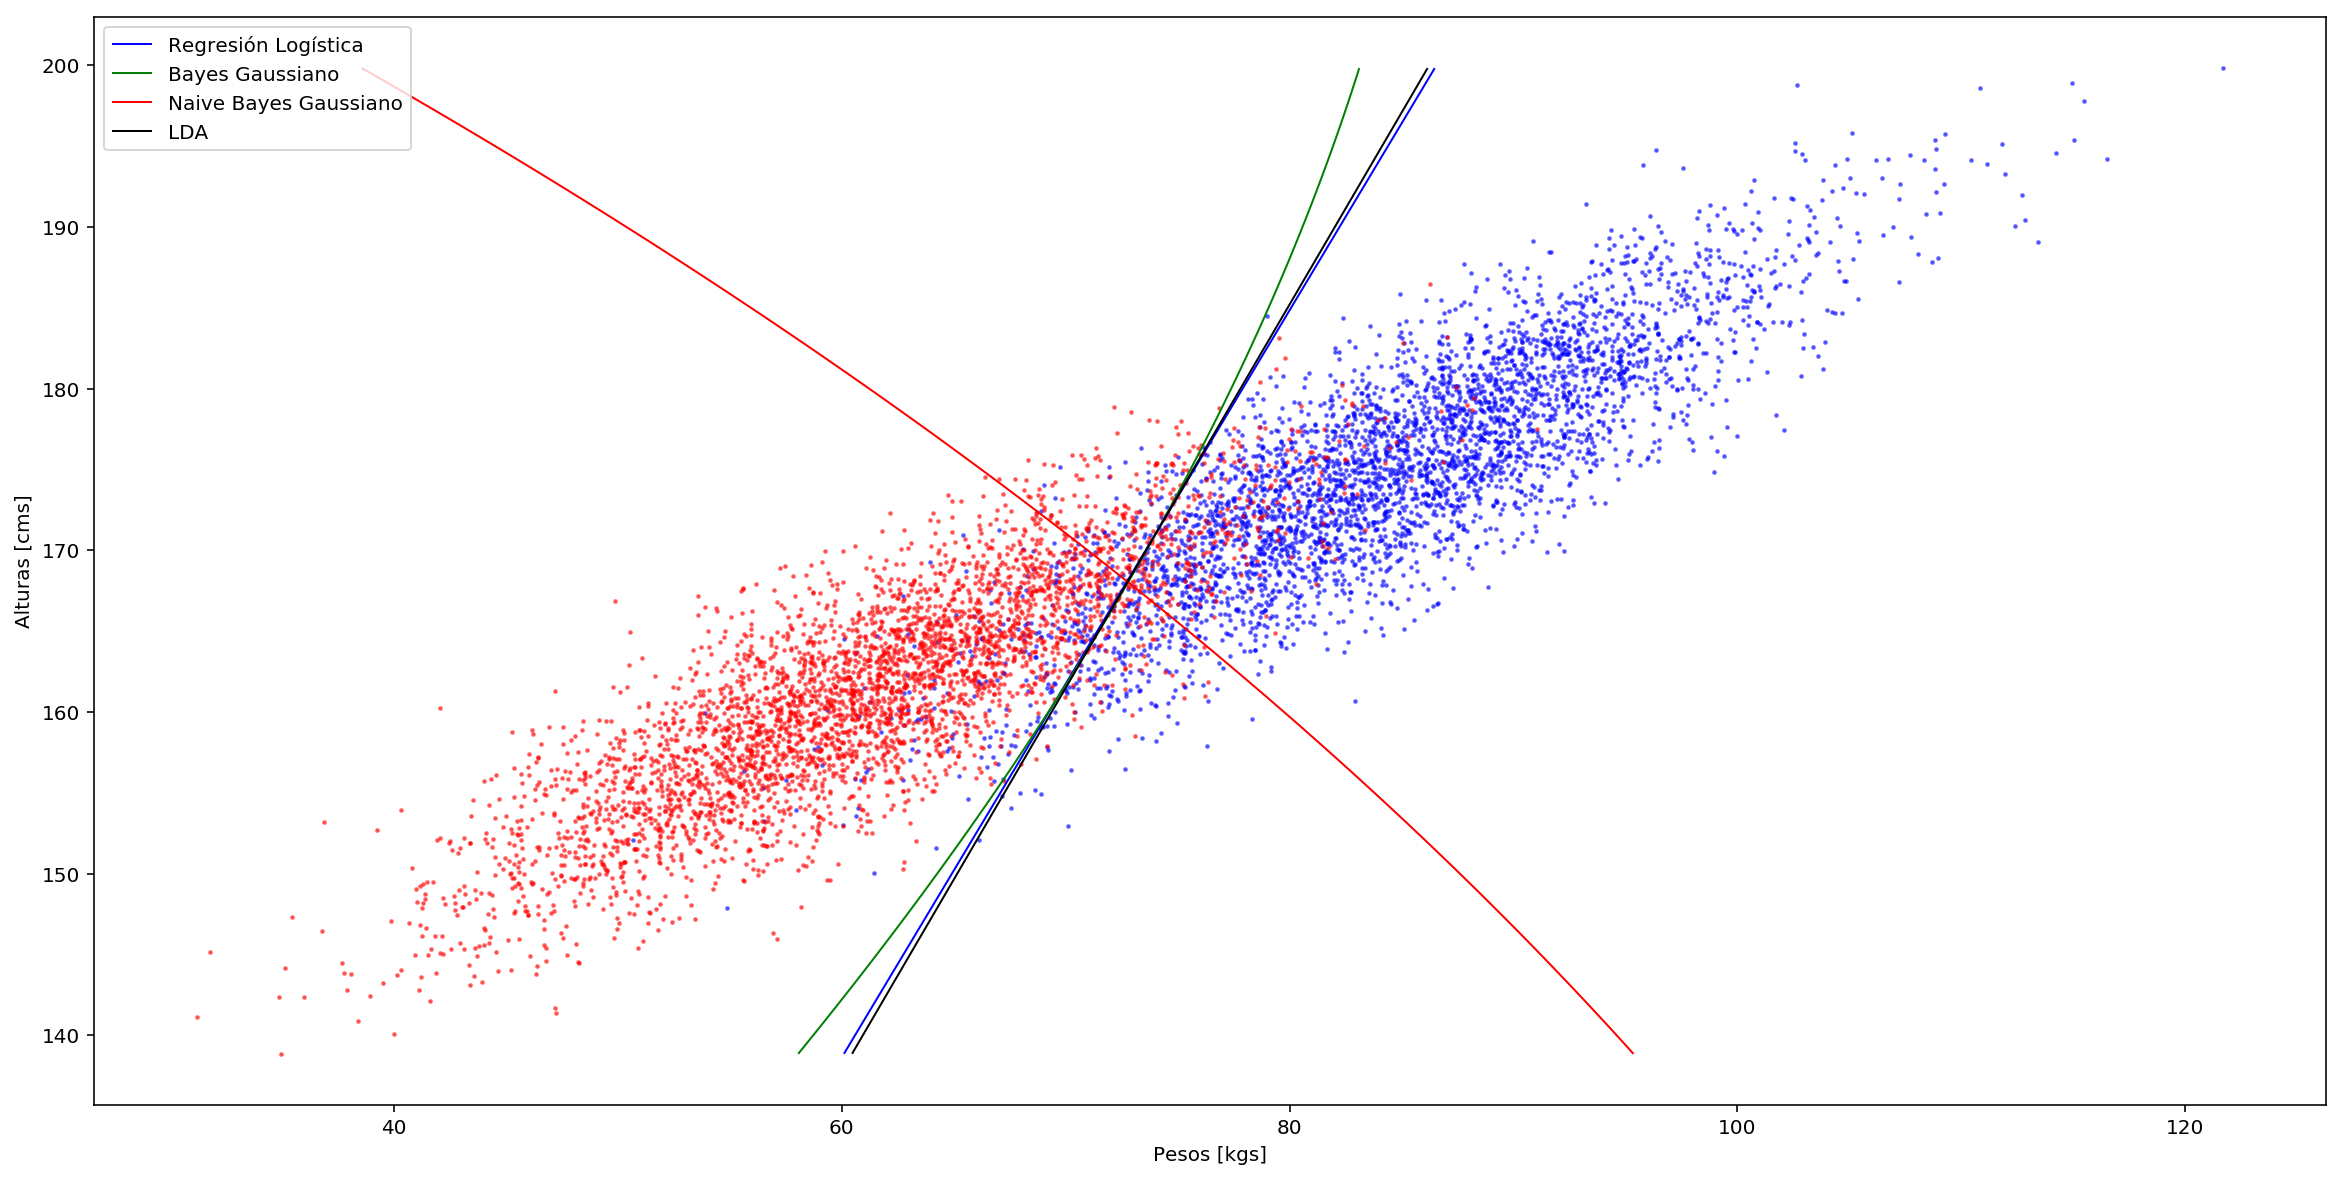

In [32]:
#%matplotlib qt
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
# cf = ax.contourf(X, Y, Z_lr, 256, alpha=.5, vmin=0., vmax=1., cmap=cm)
cs1 = ax.contour(X, Y, Z_lr, (0.5,), colors='b', linewidths=1)
cs2 = ax.contour(X, Y, Z_gaus, (0.5,), colors='g', linewidths=1)
cs3 = ax.contour(X, Y, Z_nb, (0.5,), colors='r', linewidths=1)
cs4 = ax.contour(X, Y, Z_LDA, (0.5,), colors='k', linewidths=1)
#ax.contour(X, Y, Z_H, z_levels, linewidths=0.5)
#ax.contour(X, Y, Z_M, z_levels, linewidths=0.5)
plt.scatter(data_hombres[:,0], data_hombres[:,1], color='b', s=2, alpha=0.5)
plt.scatter(data_mujeres[:,0], data_mujeres[:,1], color='r', s=2, alpha=0.5)
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
cs1.collections[0].set_label("Regresión Logística")
cs2.collections[0].set_label("Bayes Gaussiano")
cs3.collections[0].set_label("Naive Bayes Gaussiano")
cs4.collections[0].set_label("LDA")
plt.legend()
plt.show()

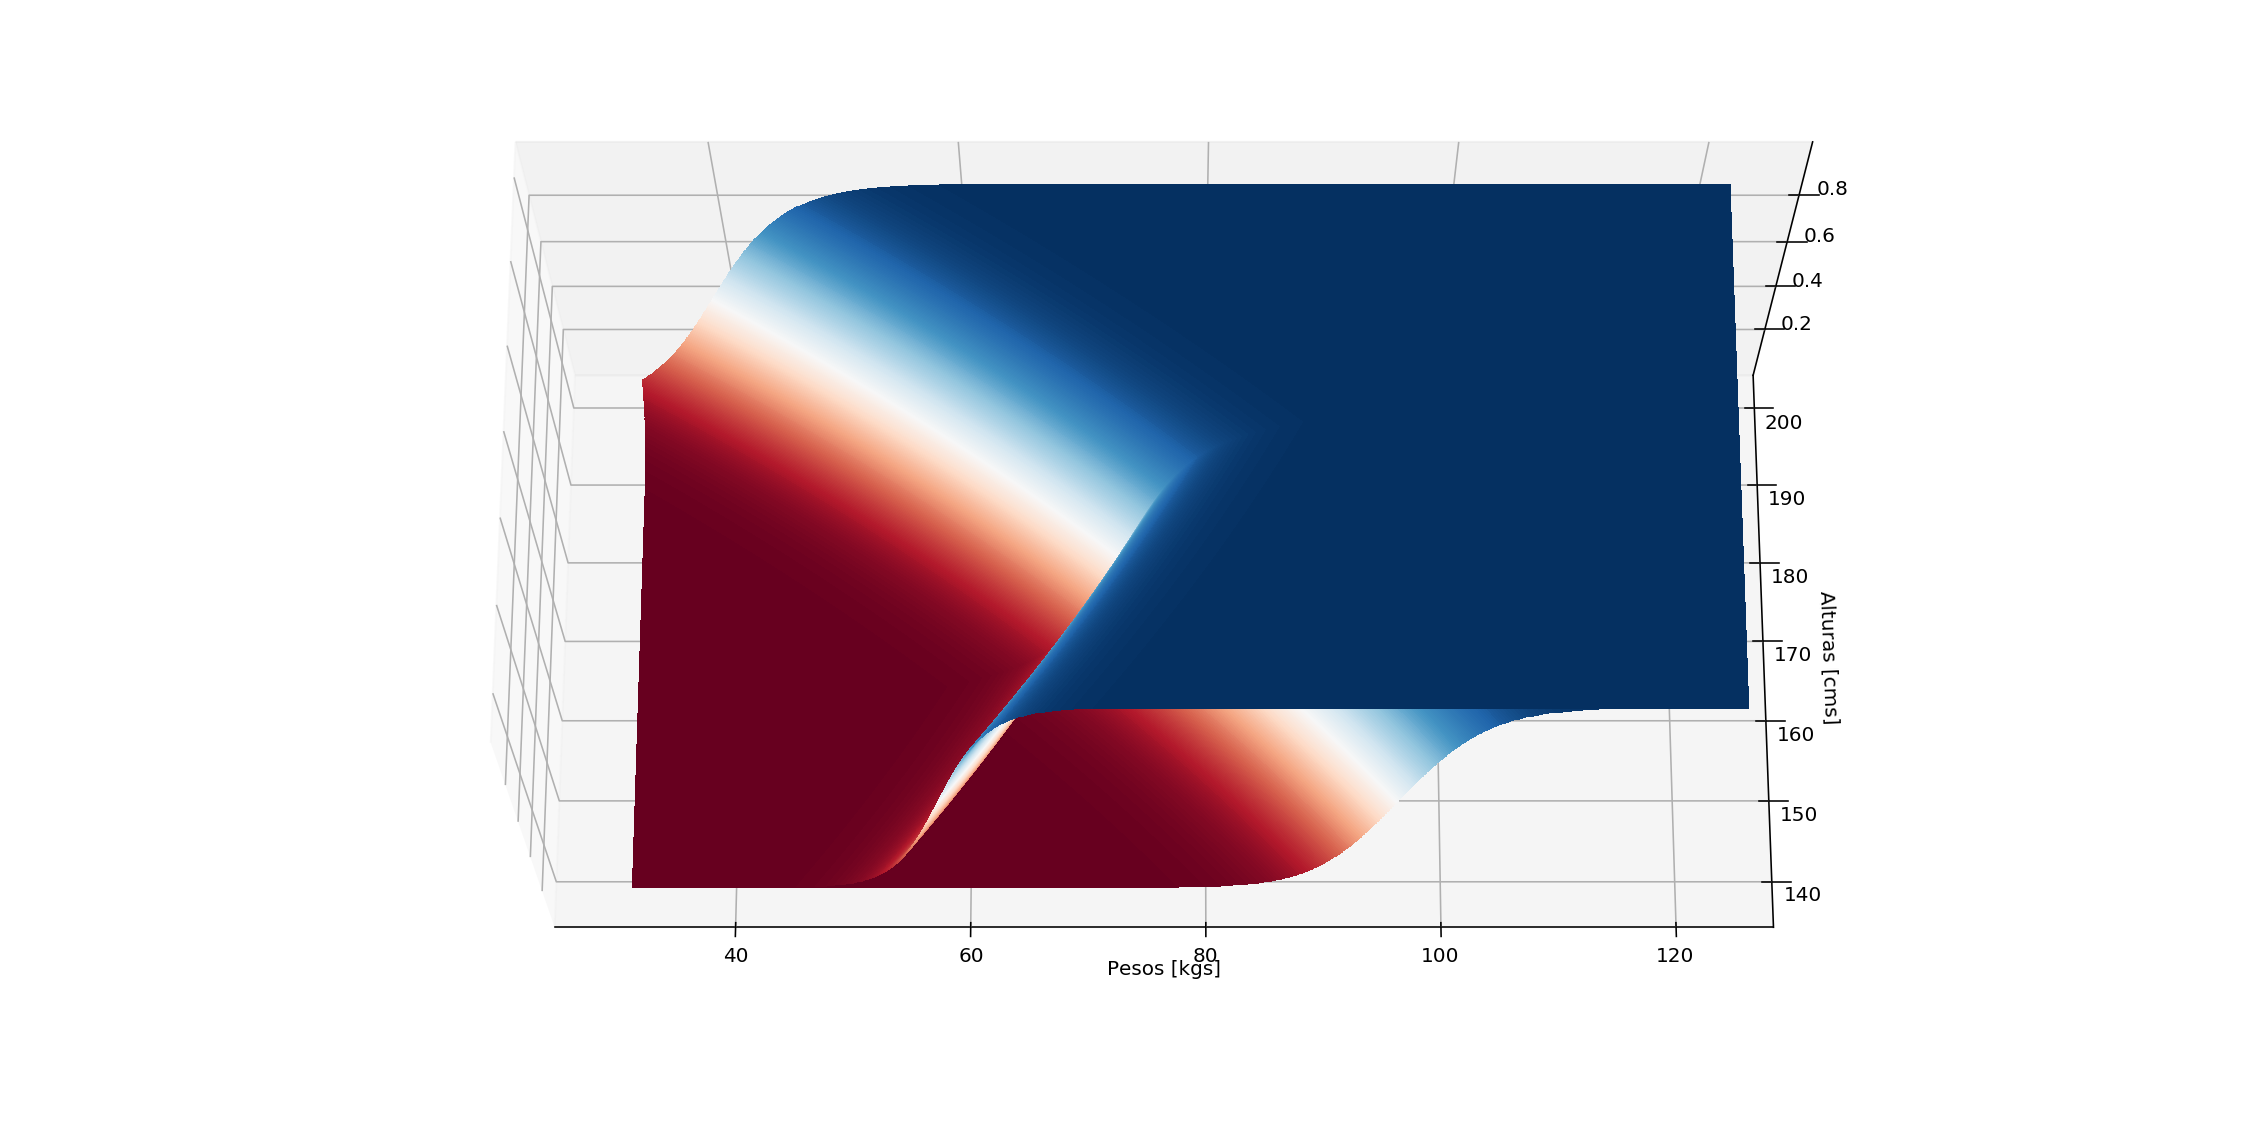

In [33]:
#%matplotlib qt
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
cm = plt.cm.RdBu
ax.contourf(X, Y, Z_nb, 256, vmin=0., vmax=1., cmap=cm)
ax.contourf(X, Y, Z_gaus, 256, vmin=0., vmax=1., cmap=cm)
# ax.set_title('TRAIN: ' + str(np.round(acc_train_LR*100)/100) + ' - CV:' + str(np.round(acc_CV_LR*100)/100))
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
ax.view_init(70, -90)
plt.show()

In [34]:
acc_QDA_train, acc_QDA_CV, acc_NB_train, acc_NB_CV, acc_LDA_train, acc_LDA_CV, acc_LR_train, acc_LR_CV

(0.9167395924490561,
 0.9225,
 0.8869858732341542,
 0.887,
 0.9167395924490561,
 0.9225,
 0.9166145768221028,
 0.922)

con 8000 ejemplos

|Modelo| tipo| Train Acc| CV Acc|Comentarios
|-| -| -| -|-|
|Gaussian|Bayes|0.92|0.92|
|Gaussian|Naive Bayes|0.89|0.89|
|LDA|-|0.92|0.92|
|Regresion Logística|-|0.92|0.92|

con 100 ejemplos

|Modelo| tipo| Train Acc| CV Acc|Comentarios
|-| -| -| -|-|
|Gaussian|Bayes|0.90|0.90|
|Gaussian|Naive Bayes|0.89|0.89|
|LDA|-|0.87|0.91|
|Regresion Logística|-|0.87|0.91|

con 8000 ejemplos

|Modelo| tipo| Train Acc| CV Acc|Comentarios
|-| -| -| -|-|
|Gaussian|Bayes|0.92|0.92|
|Gaussian|Naive Bayes|0.89|0.89|
|LDA|-|0.92|0.92|
|Regresion Logística|-|0.92|0.92|
|Histogram - step 4|Bayes|0.91|0.92|
|Histogram - step 8|Naive Bayes|0.90|0.90


con 100 ejemplos

|Modelo| tipo| Train Acc| CV Acc|Comentarios
|-| -| -| -|-|
|Gaussian|Bayes|0.90|0.90|
|Gaussian|Naive Bayes|0.89|0.89|
|LDA|-|0.87|0.91|
|Regresion Logística|-|0.87|0.91|
|Histogram - step 16|Bayes|0.86|0.87|
|Histogram - step 8|Naive Bayes|0.85|0.86